# Western Founders Network
### Machine Learning for Stock Price Prediction

This tutorial will give you a breakdown of the basics of Stock Price Predictions. We will look at the S&P 500 instrument, SPX. We will be doing Classification of whether the price of the asset will go up or down tomorrow. It is also possible to do regression to find an exact price, but this is far more difficult to do accurately.

We will use Python 3.5, one of the simplest yet most useful languages in the world. Python is easy to understand, and has a lot of libraries. SciKit-Learn, a popular Python library, along with XGBoost, a popular tree library, are what we'll use to do our Machine Learning today.

## Requirements
You should have the following:
    - Python 3.5
    - pandas 0.22.0
    - NumPy 1.14.2
    - Scikit-Learn 0.19.1
    - XGBoost 0.71
Also, have a Windows or MAC Computer (Linux may run into some issues). 

## The Actual Code
Below, you'll find all of the code we use to do our machine learning predictions. 

### Imports
Certain tasks are really standard, but difficult to code. As such, if there's something we need to do when programming, and it is common, we can usually use an external library in Python that someone else has made to get the job done!

In Machine Learning, programming a neural network and it's appropriate methods from scratch would be time-consuming and prone to error. As such, we can use libraries like Scikit-Learn, a very common library that's used in the field. 

For more serious ML work, you can look at Keras, which offers a lot more control, but keeps things easy. When you're ready to work more in-depth, using TensorFlow, PyTorch, and creating models from scratch may be more common. 

In [1]:
# Imports
import pandas as pd                          # Pandas is a useful data manipulation library
import numpy as np                           # Numpy is a useful computational library, that's also fast!
import xgboost as xgb                        # XGBoost is one library we will use for ML. 
import sklearn as sk                         # Scikit-Learn will be the basis of our ML today

### Data Importing and Processing
First, we need to get our data into a format that's easy to work with in Python. Here, we have a CSV with Open, High, Low, Close, and Volume (OHLC&V) data. We're going to import the CSV into a Pandas Data Frame. This is a data structure used by Pandas. 

Here we're using OHLC and Volume as our features. It's really important to choose the best available features to you if you ever want to improve your model's performance. We'll engineer a few very basic features here. This model will perform poorly as we are using raw values of OHLC and Volume (which tend to increase overtime), and as such, we won't make meaningful relations from the data - but this is where you have to consider, what features make sense. As long as you can understand the model, and make great features, you can do well! We will also drop any empty cells, and create a label, called Label. The label is what we're trying to predict, and it indicates whether the price of the stock will go up or down tomorrow (1 and 0 respectively). 

In [2]:
# Import the data from a CSV of OHLC and Volume Data
data = pd.read_csv(r"C:\Users\Drew\Documents\Tutorials\SPX_data.csv", index_col=0)

In [3]:
# Engineer some basic features to enhance data
# Return on a daily basis
data["Close Return"] = data["Close"].pct_change()
# First derivative of Volume
data['Volume Velocity'] = data['Volume'].diff()
# Second derivative on volume
data['Volume Acceleration'] = data['Volume Velocity'].diff()
# Change in volume as a percent on a daily
data['Volume Percent'] = data['Volume'].pct_change()
# Calculate the moving averages
data['SMA'] = data['Close'].rolling(window=10).mean()
data['EMA'] = data['Close'].ewm(span=30).mean()

# Convert the index to date time format, so that it is easier to work with
data.index = pd.to_datetime(data.index)
# Drop the NA cells
data= data.dropna(how="any")

#Label assigned, 0 for sell, and 1 for buy
data["Label"] = np.where(data["Close"] > (data["Close"].shift(-1)), 0, 1)


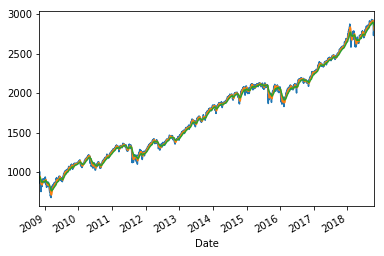

In [8]:
# Plot the close prices
data['Close'].plot()
data['SMA'].plot()
data['EMA'].plot()

### Data Preparation and Normalization
ML models need data to train and make predictions accurately. As such, you need a training set of data and a testing set. From an original dataset, a split can be made. 

The train will be used to train and improve the model through each iteration, and the test set will be used later to evaluate. 

We also have an important step called normalization. Normalizing gets all of our data in the same range (0 to 1) based on the train set. In doing so, we rescale appropriately, and make it easier for our model to train on the data. Normalizing simply takes your data and scales it to a normal range. Usually, this range is between 0 and 1, however, it can also be from -1 to 1. We set our normalizing parameters based on the Std dev and mean of our training set, so we may get values above 1 in our test set. There are numerous reasons for this, which I won't get into. We can use Scikit-learn for this, which makes things really easy. Here, we assign our maximum value 1, and minimum 0.

Lastly, we'll want to create an X and y component of both train and test. In both, the X component is the data our model can see (OHLC and Volume), and they label is the data our model is supposed to try and predict. We'll split the data by dropping the label for X, and only including the label for y.

We will also use a rebalance function to demonstrate some bias removal and a way to enhance the data you have to be a better teacher for your model. The thinking here is that 60% of the time, the stock market may go up. If this is the case, the prediction will try to do the best statistically and always predict buy as an output, which isn't helpful. This step serves to make the number of buys and the number of cells equal in our training set. 

In [9]:
# Split the data
train_data = data['1990-01-01':'2010-12-31'].copy()
test_data = data['2011-01-01':'2018-01-01'].copy()

In [10]:
# Rebalance the training set
from sklearn.utils import resample
def rebalance(unbalanced_data):
    # Separate majority and minority classes
    data_minority = unbalanced_data[unbalanced_data["Label"] == 0]
    data_majority = unbalanced_data[unbalanced_data["Label"] == 1]
    # Upsample minority class
    n_samples = len(data_majority)
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=n_samples, random_state=5)
    # Combine majority class with upsampled minority class
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])
    data_upsampled.sort_index(inplace=True)
    # Display new class counts
    data_upsampled["Label"].value_counts()
    return data_upsampled
train_data = rebalance(train_data)

In [11]:
# Normalize the data
scaler = sk.preprocessing.MinMaxScaler()
scaler.fit(train_data)
train_data.loc[:, train_data.columns] = scaler.transform(train_data)
test_data.loc[:,test_data.columns] = scaler.transform(test_data)

In [12]:
# Train and Test Data and Label Assignment
X_train = train_data.drop("Label",1)
y_train = train_data["Label"]
X_test = test_data.drop("Label",1)
y_test = test_data["Label"]

### Machine Learning Portion
Now that we've processed some of our data, we can finally start with the ML, what we've been waiting for!

We're going to be using sklearn to make three models. Feel free to play around with the parameters for each model a bit and see how it affects performance!

Let's talk about parameters. Parameters are just some basic rules and instructions for our model to follow while it's fitting the model, all to make sure that it trains how we want it to. We use a variety of different parameters, and they change based on the model we fit. Here, we'll be fitting the following:
    - Fully Connected Neural Network
    - Extreme Gradient Boosting
    - SVM

Then, the big show! We'll train our model by passing in our parameters, our train data, and for a specified number of rounds. This will take a few seconds
to a few minutes to process depending on how much data you've pulled. This  trained model can then be used to predict output labels.

When we're done, we can test accuracy against the real numbers that are labels for our test set. 

In [13]:
# We want to be able to compute accuracy
from sklearn.metrics import accuracy_score

In [14]:
# The Neural Network
# This block will use the Multi-layer Perceptron from sklearn to create a neural network, train it, and predict using it. 

# Import
from sklearn.neural_network import MLPClassifier
# Create the object mlp as a case of MLPClassifier with 3, 30-neuron hidden layers. 
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', alpha=1e-05, learning_rate_init=0.001,max_iter=500)
# We fit the model here
mlp.fit(X_train, y_train)
# And make predictions here
predictions = mlp.predict(X_test)
# Computer Accuracy
accuracytest = accuracy = (accuracy_score(y_test, predictions))
# Print the accuracy
print("Accuracy on test set was {0}%.".format(accuracytest*100))

Accuracy on test set was 54.230550823395795%.


In [15]:
# The Boosted Tree
# This block will use the eXtreme Gradient BOOSTing from XGBoost to create a tree, train on it, and predict using it. 
# XGBoost creates trees similar to decision trees based on the input vector. 

# Import
from xgboost import XGBClassifier
# Create the object model as a case of XGBClassifier with the default parameters
model = XGBClassifier()
# Fit the model here
model.fit(X_train, y_train)
# And make predictions here
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# Computer Accuracy
accuracytest = accuracy = (accuracy_score(y_test, predictions))
# Print the accuracy
print("Accuracy on test set was {0}%.".format(accuracytest*100))

Accuracy on test set was 53.208404315729695%.


C:\Users\Drew\AppData\Local\Continuum\anaconda3\envs\Python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
# The Support Vector Machine
# This block uses the LinearSVC from sklearn to create and train a support vector machine with default parameters and predict

# Imports
from sklearn.svm import LinearSVC
# Create the object clf as a case of the LinearSVC with default parameters
clf = LinearSVC(random_state=0, tol=1e-5)
# Train the model here
clf.fit(X_train, y_train)
# And make predictions here
predictions = clf.predict(X_test)
# Computer Accuracy
accuracytest = accuracy = (accuracy_score(y_test, predictions))
# Print the accuracy
print("Accuracy on test set was {0}%.".format(accuracytest*100))

Accuracy on test set was 47.018739352640544%.
